# Detecting and Classifying Skin Cancers With CNN Model

### Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [16]:
import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam, SGD

from imblearn.over_sampling import SMOTE

## Clean and Prepare Training Data

### Load Dataset of Skin Images From Kaggle

In [3]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d farjanakabirsamanta/skin-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset
License(s): other
100% 2.57G/2.58G [00:31<00:00, 101MB/s] 
100% 2.58G/2.58G [00:31<00:00, 87.3MB/s]


In [5]:
# Extract skin images from our zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Separating Images Based on Skin Cancer Types

In [6]:
# Display first 5 lines of csv file
meta_data = pd.read_csv('/content/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
print("Unique Cancer Types Represented in the Data")
print(meta_data.dx.unique(), "\n")

# Handle Categorical Data
encoder = LabelEncoder()
meta_data['dx_label'] = encoder.fit_transform(meta_data['dx'])

# Display labels and interger encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer Types Represented in the Data
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [8]:
img_path = "/content/Skin Cancer/Skin Cancer/"
files = os.listdir(img_path)

image_files = [file for file in files if file.endswith('.jpg')]

# Count number of images in folder
num_images = len(image_files)
print(f"Number of images in the folder: {num_images}")

Number of images in the folder: 10015


In [9]:
training_dir = "/content/Training_Set"
os.makedirs(training_dir, exist_ok=True)

In [10]:
# Group images by cancer type
cancer_types = meta_data['dx'].unique()

# Copy images to seperated directories based on cancer type
for cancer_type in cancer_types:
  # Create directory for each cancer type within training directory
    cancer_type_dir = os.path.join(training_dir, cancer_type)
    os.makedirs(cancer_type_dir, exist_ok=True)

    # Filter images corresponding to the current cancer type
    images_of_cancer_type = meta_data[meta_data['dx'] == cancer_type]['image_id'].values

    # Copy images to the corresponding directory
    for image_name in images_of_cancer_type:
        source_path = os.path.join(img_path, image_name + '.jpg')
        destination_path = os.path.join(cancer_type_dir, image_name + '.jpg')
        shutil.copy(source_path, destination_path)

In [11]:
# Get list of subdirectories within the train directory
subdirs = [subdir for subdir in os.listdir(training_dir) if os.path.isdir(os.path.join(training_dir, subdir))]

# Print the subdirectories and count of images in each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(training_dir, subdir)
    num_images = len(os.listdir(subdir_path))
    print(f"Subdirectory: {subdir}, Number of Images: {num_images}")

Subdirectory: bkl, Number of Images: 1099
Subdirectory: bcc, Number of Images: 514
Subdirectory: nv, Number of Images: 6705
Subdirectory: df, Number of Images: 115
Subdirectory: vasc, Number of Images: 142
Subdirectory: akiec, Number of Images: 327
Subdirectory: mel, Number of Images: 1113


### Define Paths for our Skin Images

In [12]:
dirpath = os.getcwd()
PATH = os.path.join(dirpath, 'Training_Set')
PATH_ak = os.path.join(PATH, 'akiec')
PATH_bcc = os.path.join(PATH, 'bcc')
PATH_derm = os.path.join(PATH, 'df')
PATH_mel = os.path.join(PATH, 'mel')
PATH_nev = os.path.join(PATH, 'nv')
PATH_bkl = os.path.join(PATH, 'bkl')
PATH_vl = os.path.join(PATH, 'vasc')
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'benign keratosis', 'vascular lesion']

### Divide Paths for Images in Each Category


In [13]:
files_ak = os.listdir(PATH_ak)
files_bcc = os.listdir(PATH_bcc)
files_derm = os.listdir(PATH_derm)
files_mel = os.listdir(PATH_mel)
files_nev = os.listdir(PATH_nev)
files_bkl = os.listdir(PATH_bkl)
files_vl = os.listdir(PATH_vl)
print(len(files_ak), len(files_bcc), len(files_derm), len(files_mel), len(files_nev), len(files_bkl), len(files_vl))

paths_ak = [os.path.join(PATH_ak, file) for file in files_ak]
paths_bcc = [os.path.join(PATH_bcc, file) for file in files_bcc]
paths_derm = [os.path.join(PATH_derm, file) for file in files_derm]
paths_mel = [os.path.join(PATH_mel, file) for file in files_mel]
paths_nev = [os.path.join(PATH_nev, file) for file in files_nev]
paths_bkl = [os.path.join(PATH_bkl, file) for file in files_bkl]
paths_val = [os.path.join(PATH_vl, file) for file in files_vl]

# Number of paths per skin cancer category
paths_all = np.concatenate([paths_ak, paths_bcc, paths_derm, paths_mel, paths_nev, paths_bkl, paths_val])

327 514 115 1113 6705 1099 142


### Crop our Images and Define New Paths

In [14]:
# Set a target size to crop our images at
target_size =  (250, 250)

# Define function to center crop our images
def crop_center_opencv(image, size):
  height, width = image.shape[:2]
  top = (height - size[1]) // 2
  bottom = top + size[1]
  left = (width - size[0]) // 2
  right = left + size[0]
  return image[top:bottom, left:right]

category_paths = [PATH_ak, PATH_bcc, PATH_derm,  PATH_mel, PATH_nev, PATH_bkl, PATH_vl]

# Create directory folder to store our cropped images
cropped_dir = os.path.join(dirpath, 'Cropped_Images')
os.makedirs(cropped_dir, exist_ok=True)

# Nested for loops to resize and crop our images for processing
for i, category_path in enumerate(category_paths):
  category_name = class_names[i]
  save_dir = os.path.join(cropped_dir, category_name)
  os.makedirs(save_dir, exist_ok=True)

  files = os.listdir(category_path)

  for file in files:
    image_path = os.path.join(category_path, file)
    image = cv2.imread(image_path)

    height, width = image.shape[:2]
    if height < width:
      new_height = target_size[1]
      new_width = int(width * (new_height / height))
    else:
      new_width = target_size[0]
      new_height = int(height * (new_width / width))

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    cropped_image = crop_center_opencv(resized_image, target_size)

    save_path = os.path.join(save_dir, file)
    cv2.imwrite(save_path, cropped_image)

print("All images have been cropped and saved")

# Create paths for our cropped images
cropped_PATH = os.path.join(dirpath, 'Cropped_Images')
cropped_ak = os.path.join(cropped_PATH, 'actinic keratosis')
cropped_bcc = os.path.join(cropped_PATH, 'basal cell carcinoma')
cropped_derm = os.path.join(cropped_PATH, 'dermatofibroma')
cropped_mel = os.path.join(cropped_PATH, 'melanoma')
cropped_nev = os.path.join(cropped_PATH, 'melanocytic nevi')
cropped_bkl = os.path.join(cropped_PATH, 'benign keratosis')
cropped_vl = os.path.join(cropped_PATH, 'vascular lesion')

cropped_files_ak = os.listdir(cropped_ak)
cropped_files_bcc = os.listdir(cropped_bcc)
cropped_files_derm = os.listdir(cropped_derm)
cropped_files_mel = os.listdir(cropped_mel)
cropped_files_nev = os.listdir(cropped_nev)
cropped_files_pbk = os.listdir(cropped_bkl)
cropped_files_vl = os.listdir(cropped_vl)

cropped_paths_ak = [os.path.join(cropped_ak, file) for file in cropped_files_ak]
cropped_paths_bcc = [os.path.join(cropped_bcc, file) for file in cropped_files_bcc]
cropped_paths_derm = [os.path.join(cropped_derm, file) for file in cropped_files_derm]
cropped_paths_mel = [os.path.join(cropped_mel, file) for file in cropped_files_mel]
cropped_paths_nev = [os.path.join(cropped_nev, file) for file in cropped_files_nev]
cropped_paths_bkl = [os.path.join(cropped_bkl, file) for file in cropped_files_pbk]
cropped_paths_val = [os.path.join(cropped_vl, file) for file in cropped_files_vl]

df_ak = pd.DataFrame({'image': cropped_paths_ak, 'label': class_names[0]})
df_bcc = pd.DataFrame({'image': cropped_paths_bcc, 'label': class_names[1]})
df_derm = pd.DataFrame({'image': cropped_paths_derm, 'label': class_names[2]})
df_mel = pd.DataFrame({'image': cropped_paths_mel, 'label': class_names[3]})
df_nev = pd.DataFrame({'image': cropped_paths_nev, 'label': class_names[4]})
df_bkl = pd.DataFrame({'image': cropped_paths_bkl, 'label': class_names[5]})
df_vl = pd.DataFrame({'image': cropped_paths_val, 'label': class_names[6]})

# DataFrame of image paths and their label to train
train_data = pd.concat([df_ak, df_bcc, df_derm, df_mel, df_nev, df_bkl, df_vl])

All images have been cropped and saved


## Cancer Detection With Convolutional Connected Network (CNN)
#### Create train and validation data from our cropped images for our CNN

In [18]:
df_train, df_test = train_test_split(train_data,
                                     test_size=.2,
                                     stratify=train_data.label,
                                     shuffle=True,
                                     random_state=41)
df_train, df_val = train_test_split(df_train,
                                    test_size=.1,
                                    stratify=df_train.label,
                                    shuffle=True,
                                    random_state=41)

In [19]:
# Set image size and batch size for training
image_size = (250, 250)
batch_size = 32

# Create an ImageDataGenerator Object for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255
)

# Create train_batches using flow_from_directory
train_batches = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes= class_names,
    shuffle = True
)

# Create test_batches using flow_from_directory
test_batches = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes = class_names,
    shuffle = False
)

# Create validation set using flow_from_directory
val_batches = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes = class_names,
    shuffle = False
)

Found 7210 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 802 validated image filenames belonging to 7 classes.


### Define the Architecture of our CNN Model

In [20]:
from tensorflow.keras import backend as K

# Clearing previous models from memory
K.clear_session()

# Intialize a sequential model
model_cnn=keras.models.Sequential()

# Add first convolution layer of 32 filters of size 3x3 with stride 2
model_cnn.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(256,256, 3)))
# Add a max pooling layer of size 2x2 with stride 2
model_cnn.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))

# Add second convolution layer of 64 filters of size 3x3 with stride 2
model_cnn.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
# Add a max pooling layer of size 2x2 with stride 2
model_cnn.add(keras.layers.MaxPool2D((2,2),2,padding='same'))

# Add third convolution layer of 128 filters of size 3x3 with stride 2
model_cnn.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
# Add a thrid max pooling layer of size 2x2 with stride 2
model_cnn.add(keras.layers.MaxPool2D((2,2),2,padding='same'))

# Flatten output from previous layers
model_cnn.add(keras.layers.Flatten())

# Add a fully connected dense layer of 1024 neurons
model_cnn.add(keras.layers.Dense(1024,activation='relu'))

# Add dropout layer (30% of neurons will be randomly turned off to prevent overfitting)
model_cnn.add(keras.layers.Dropout(0.3))

# Add output layer of 9 neuros (one for each class)
model_cnn.add(keras.layers.Dense(7,activation='softmax'))

# Display model architecture
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,198,599 (8.39 MB)

 Trainable params: 2,198,599 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

### Define Handy Callback Function

In [21]:
sub_dir = 'CNN Model'
# Folder name to save our model
model_folder = 'model_cnn'
# Path to save our CNN model to
checkpoint_file = os.path.join(dirpath, sub_dir, model_folder, 'checkpoint.model.keras')
# Saves the model only if its performance improves
checkpoint_cb = ModelCheckpoint(checkpoint_file, save_best_only=True)
# Stop early if model's performance doesn't imporve for 5 epochs
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
# Model compilation
model_cnn.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.AUC()])
# Train our model
hist=model_cnn.fit(train_batches,
               validation_data = val_batches,
               epochs=50,
               callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 169s 734ms/step - accuracy: 0.6578 - auc: 0.8892 - loss: 1.1092 - specificity_at_sensitivity: 0.9711 - val_accuracy: 0.6746 - val_auc: 0.9272 - val_loss: 0.9254 - val_specificity_at_sensitivity: 0.9842
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 184s 655ms/step - accuracy: 0.6805 - auc: 0.9305 - loss: 0.9071 - specificity_at_sensitivity: 0.9857 - val_accuracy: 0.6658 - val_auc: 0.9353 - val_loss: 0.9002 - val_specificity_at_sensitivity: 0.9834
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 200s 649ms/step - accuracy: 0.6896 - auc: 0.9383 - loss: 0.8544 - specificity_at_sensitivity: 0.9869 - val_accuracy: 0.7045 - val_auc: 0.9471 - val_loss: 0.7956 - val_specificity_at_sensitivity: 0.9877
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 204s 658ms/step - accuracy: 0.6863 - auc: 0.9418 - loss: 0.8295 - specificity_at_sensitivity: 0.9869 - val_accuracy: 0.7057 - val_auc: 0.9444 - val_loss: 0.8126 - val_specificity_at_sensitivity: 0.9855
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 144

### Outputting Results of Model

In [22]:
# Create a dataframe of our training session and store it in google drive
hist_cnn=pd.DataFrame(hist.history)
hist_cnn.to_csv('/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/cnn_output.csv', index=False)
hist_cnn

,accuracy,auc,loss,specificity_at_sensitivity,val_accuracy,val_auc,val_loss,val_specificity_at_sensitivity
0,0.666852,0.910838,1.016294,0.978826,0.674564,0.927208,0.925381,0.984206
1,0.679750,0.931199,0.901510,0.985807,0.665835,0.935301,0.900244,0.983375
2,0.689736,0.940046,0.842959,0.987078,0.704489,0.947088,0.795550,0.987739
3,0.699307,0.945778,0.801471,0.988280,0.705736,0.944441,0.812629,0.985453
4,0.715118,0.950007,0.768260,0.990153,0.710723,0.954380,0.745266,0.990025
5,0.726768,0.953494,0.742380,0.990407,0.721945,0.951830,0.754037,0.988570
6,0.733287,0.957878,0.706545,0.992094,0.746883,0.959903,0.693474,0.991687
7,0.742718,0.959884,0.687856,0.992926,0.748130,0.962281,0.670375,0.993142
8,0.756727,0.964019,0.651877,0.994175,0.743142,0.959575,0.697262,0.992103
9,0.769903,0.968153,0.611745,0.995238,0.759352,0.960866,0.679236,0.991687


### Plot training and validation accuracy to assess model training

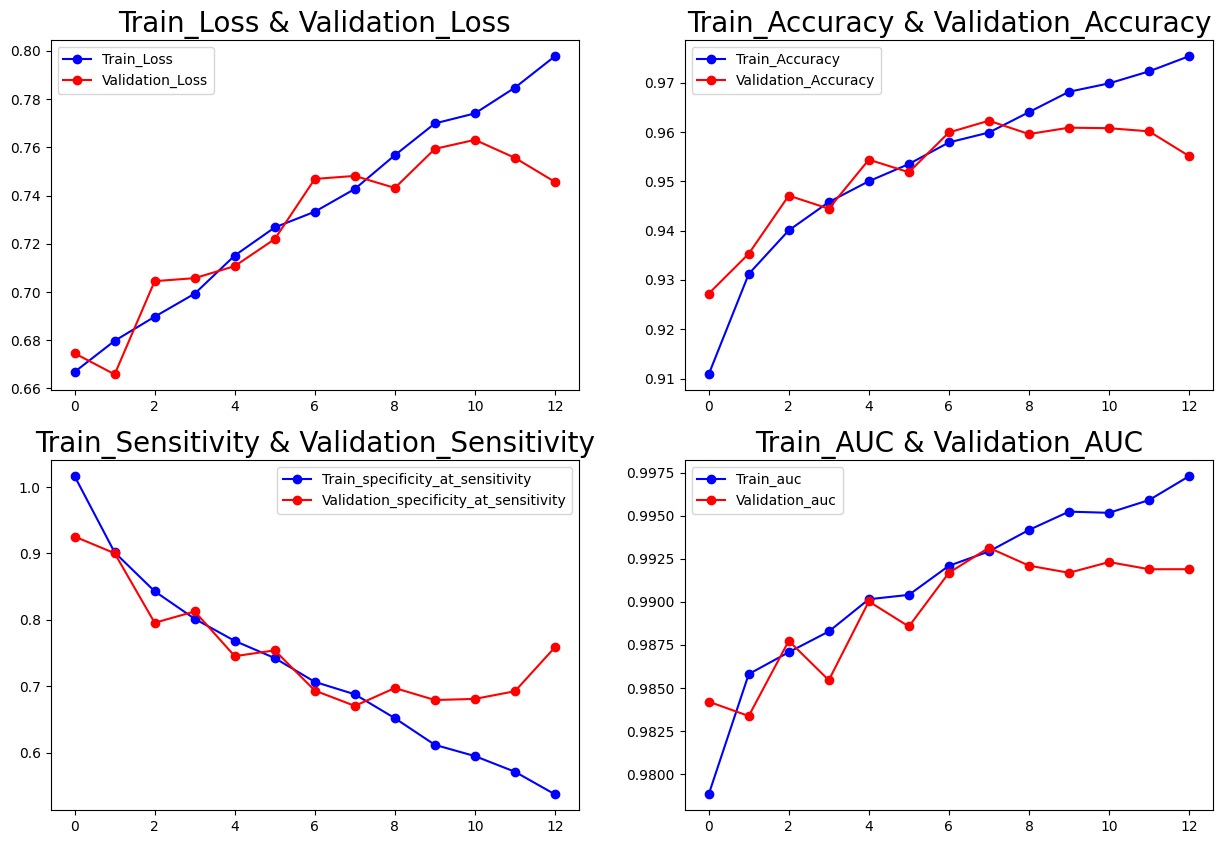

In [23]:
# Create plot of Train Loss and Validation Loss
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_cnn.iloc[:,0],'b-o',label='Train_Loss')
plt.plot(hist_cnn.iloc[:,4],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
# Create plot of Train Accuracy and Validation Accuracy
plt.subplot(2,2,2)
plt.plot(hist_cnn.iloc[:,1],'b-o',label='Train_Accuracy')
plt.plot(hist_cnn.iloc[:,5],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
# Create plot of Train Sesitivity and Validation Sensitivity
plt.subplot(2,2,3)
plt.plot(hist_cnn.iloc[:,2],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_cnn.iloc[:,6],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
# Create plot of Train AUC and Validation AUC
plt.subplot(2,2,4)
plt.plot(hist_cnn.iloc[:,3],'b-o',label='Train_auc')
plt.plot(hist_cnn.iloc[:,7],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

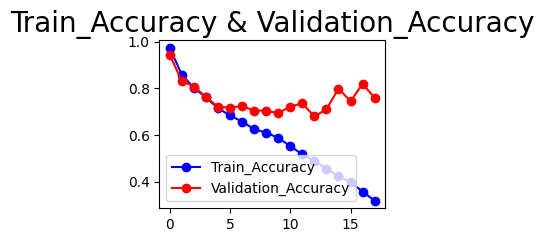

In [19]:
# Create plot of Train Accuracy and Validation Accuracy
plt.subplot(2,2,2)
plt.plot(hist_cnn.iloc[:,1],'b-o',label='Train_Accuracy')
plt.plot(hist_cnn.iloc[:,3],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

### Model Evaluation

In [24]:
score, acc,sensitivity,auc = model_cnn.evaluate(train_batches)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

226/226 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - accuracy: 0.7641 - auc: 0.9679 - loss: 0.6151 - specificity_at_sensitivity: 0.9950
Test Loss = 0.6115588545799255
Test Accuracy = 0.768515944480896
Test Sensitivity = 0.9950762987136841
Test AUC = 0.9682307839393616


#### F1 score

In [25]:
# Make predictions on the validation set
predictions = model_cnn.predict(test_batches, len(test_batches), verbose = 1)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_batches.classes  # Convert true labels if in categorical format

# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"F1 Score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step
F1 Score: 0.7107


### Predicting Test Data with our Model

In [26]:
predictions = model_cnn.predict(test_batches, len(test_batches), verbose = 1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_batches.classes
y_test = np.ravel(true_labels)
y_pred = np.ravel(predicted_labels)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step


,Actual,Prediction
0,4,4
1,4,4
2,4,4
3,4,4
4,4,4
...,...,...
1998,5,4
1999,1,1
2000,4,4
2001,4,4


### Confusion Matrix of CNN Model

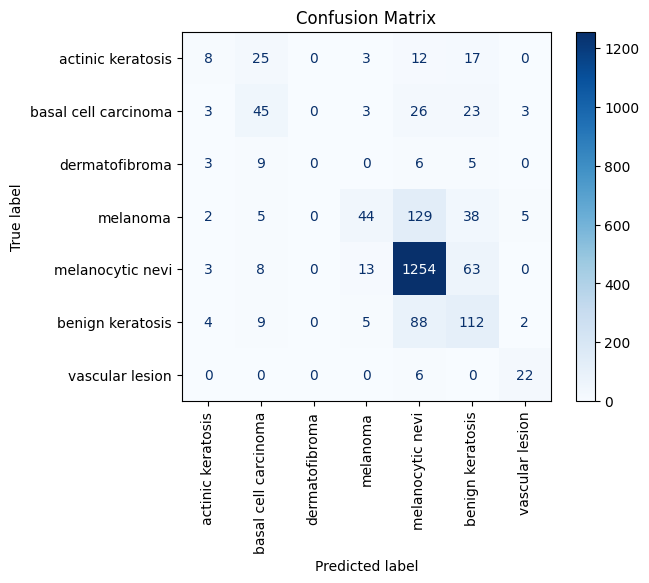

In [27]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)

# Show the plot
plt.show()

### Skin Cancer Classification Using our CNN Model


In [23]:
cnn_model = keras.models.load_model('/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn/checkpoint.model.keras')

def prdict_image(image_path):
  img = image.load_img(image_path, target_size=(250, 250))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  predictions = cnn_model.predict(img_array)
  predicted_class = np.argmax(predictions)

  return predicted_class

img_path = '/content/Cropped_Images/vascular lesion/ISIC_0024747.jpg'
predicted_class = prdict_image(img_path)

print(f"Predicted Class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted Class: vascular lesion


## Zip Model Folders and Transfer Files to Google Drive

In [31]:
# Create a zip file of our CNN model
!zip -r '/content/model_cnn.zip' '/content/CNN Model/model_cnn'

  adding: content/CNN Model/model_cnn/ (stored 0%)
  adding: content/CNN Model/model_cnn/checkpoint.model.keras (deflated 19%)


In [33]:
# Transfer all files to our google drive folder
!sudo cp -v -r "/content/CNN Model/model_cnn/" "/content/drive/MyDrive/Skin_Lesion_Project/CNN Model"
!sudo cp -v -r "/content/model_cnn.zip" "/content/drive/MyDrive/Skin_Lesion_Project/CNN Model"


'/content/CNN Model/model_cnn/' -> '/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn'
'/content/CNN Model/model_cnn/checkpoint.model.keras' -> '/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn/checkpoint.model.keras'
'/content/model_cnn.zip' -> '/content/drive/MyDrive/Skin_Lesion_Project/CNN Model/model_cnn.zip'
